# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier


from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


# magic word for producing visualizations in notebook
%matplotlib inline

# For displaying max number of lines
pd.set_option("display.max_rows", 500)

# For reproducability
SEED = 2

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
#Loadint the raw data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The warning says columns 18 and 19 have mixed data types, we can explore these two columns in later steps. This is one point to remember.

In [3]:
#Loading the attributes files
# Ignore any empty columns while loading data
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
attributes_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)  

### Data Wrangling

>After loading the dataset, I checked for cleanliness, and then trim and clean the dataset to answer the goal questions.

#### General Properties

In [4]:
print("Azdias shape -",azdias.shape)
print("Customers shape -",customers.shape)

Azdias shape - (891221, 366)
Customers shape - (191652, 369)


In [5]:
print("Number of columns in Customers Data - ", len(list(customers.columns)))
print("Number of columns in Azdius Data - ", len(list(azdias.columns)))

extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in Customers Data - ",extra_cols_in_customers)

Number of columns in Customers Data -  369
Number of columns in Azdius Data -  366
Extra columns in Customers Data -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


The shapes and extra columns match the description.

In [6]:
#Checking the heads of dataframes:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
#Checking the heads of dataframes:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


It is possible to see a lot of missing values in both of the dataframes. Looking at the extra columns in the customers dataset.

In [8]:
#Checking the heads of the extra columns in customers dataset
customers[extra_cols_in_customers].head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


Those columns are about the customers and their buying behavior. It is also available two extra dataframes with attribute information i.e. the information about what each column represents. We should check those extra dataframes in detail

**`attribute_values`** - has a description of columns in azdiasand customers data, information about range of values each column can take and their respective meanings. <br>
**`attribute_info`** - has detailed information about each column with additional notes wherever required.

In [9]:
attributes_values.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly


There are attributes with multiple rows corresponding to different values. In order to better see this table we will fill the NaN info with the correspondent attribute

In [10]:
attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
attributes_values.head(10)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,AGER_TYP,NaN,0,no classification possible
NaN,AGER_TYP,NaN,1,passive elderly
NaN,AGER_TYP,NaN,2,cultural elderly
NaN,AGER_TYP,NaN,3,experience-driven elderly
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
NaN,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
NaN,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
NaN,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [11]:
attributes_info.head(10)

,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [12]:
#Checking the warnings we got when loading the data
print(azdias.columns[18:20])
warning_cols = list(azdias.columns[18:20])

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [13]:
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUG_2015"]

,Attribute,Description,Value,Meaning
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
NaN,CAMEO_DEUG_2015,NaN,1,upper class
NaN,CAMEO_DEUG_2015,NaN,2,upper middleclass
NaN,CAMEO_DEUG_2015,NaN,3,established middleclasse
NaN,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
NaN,CAMEO_DEUG_2015,NaN,5,active middleclass
NaN,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
NaN,CAMEO_DEUG_2015,NaN,7,lower middleclass
NaN,CAMEO_DEUG_2015,NaN,8,working class
NaN,CAMEO_DEUG_2015,NaN,9,urban working class


In [14]:
#Checking the "CAMEO_INTL_2015"  attributes which is named as "CAMEO_DEUINTL_2015" in the excel sheet
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUINTL_2015"]

,Attribute,Description,Value,Meaning
NaN,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
NaN,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
NaN,CAMEO_DEUINTL_2015,NaN,12,Wealthy Households-Young Couples With Children
NaN,CAMEO_DEUINTL_2015,NaN,13,Wealthy Households-Families With School Age Ch...
NaN,CAMEO_DEUINTL_2015,NaN,14,Wealthy Households-Older Families & Mature Co...
NaN,CAMEO_DEUINTL_2015,NaN,15,Wealthy Households-Elders In Retirement
NaN,CAMEO_DEUINTL_2015,NaN,21,Prosperous Households-Pre-Family Couples & Sin...
NaN,CAMEO_DEUINTL_2015,NaN,22,Prosperous Households-Young Couples With Children
NaN,CAMEO_DEUINTL_2015,NaN,23,Prosperous Households-Families With School Age...
NaN,CAMEO_DEUINTL_2015,NaN,24,Prosperous Households-Older Families & Mature ...


Its is possible to conclude that these two columns must have values in the range given in the "Value" column: -1 for unknown and positive for corresponding categories.

In [15]:
#Checking the unique values in the dataframes
azdias[warning_cols[0]].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [16]:
#Checking the unique values in the dataframes
azdias[warning_cols[1]].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'], dtype=object)

In [17]:
#Checking the unique values in the dataframes
customers[warning_cols[0]].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [18]:
#Checking the unique values in the dataframes
customers[warning_cols[1]].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'], dtype=object)

There are null values and some 'X' and 'XX' values that are not given in the description.

These values can be replaced with 'np.nan', as in the attributes dataframe it is described that any unknown values can be treated as '-1' but for simpicity we can consider this '-1' as 'np.nan'. Also there is inconsistency in the values i.e. some of them are strings and some of them are floats. We can to convert all of them into integers.

In [19]:
def fixing_cameo_columns(df):
    """
    Function to replace 'X', 'XX' and 'nan' values with -1 in 
    columns 18 and 19 i.e. ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] 
    
    Also "CAMEO_DEU_2015", but it is dropped in later steps.
    """
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)
    
    return df

customers = fixing_cameo_columns(customers)
azdias = fixing_cameo_columns(azdias)

In [20]:
#Checking the unique values in the dataframes
azdias[warning_cols[1]].unique()

array([ nan,  51.,  24.,  12.,  43.,  54.,  22.,  14.,  13.,  15.,  33.,
        41.,  34.,  55.,  25.,  23.,  31.,  52.,  35.,  45.,  44.,  32.])

In [21]:
#Checking the unique values in the dataframes
customers[warning_cols[1]].unique()

array([ 13.,  nan,  34.,  24.,  41.,  23.,  15.,  55.,  14.,  22.,  43.,
        51.,  33.,  25.,  44.,  54.,  32.,  12.,  35.,  31.,  45.,  52.])

In [22]:
#Checkig again the shape of the dataframes
print(azdias.shape, customers.shape)

(891221, 366) (191652, 369)


#### Checking the similarity in the dataframes

In [23]:
#Converting the columns to lists
attributes_list  = attributes_values.Attribute.unique().tolist()
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)

In [24]:
#Calculating the similatiry metrics
common_to_all = (set(attributes_list) & set(azdias_list) & set(customers_list))
unique_to_azdias = (set(azdias_list) - set(attributes_list) - set(customers_list))
unique_to_customers = (set(customers_list) - set(attributes_list) - set(azdias_list))
unique_to_attributes = (set(attributes_list) - set(customers_list) - set(azdias_list))
unique_to_attributes_vs_azdias = (set(attributes_list) - set(azdias_list))
unique_to_azdias_vs_attributes = (set(attributes_list) - set(azdias_list))
common_azdias_attributes = (set(azdias_list) & set(attributes_list))

print("No of columns common to all 3 daframes: ", str(len(common_to_all)))
print("No of columns specific to azdias: " + str(len(unique_to_azdias)))
print("No of columns specific to customers: " + str(len(unique_to_customers)))
print("No of columns specific to attributes: " + str(len(unique_to_attributes)))
print("No of columns common between azdias and attributes: " + str(len(common_azdias_attributes)))
print("No of columns exclusive to attributes vs azdias: " + str(len(unique_to_attributes_vs_azdias)))
print("No of columns exclusive to azdias vs attributes: " + str(len(unique_to_azdias_vs_attributes)))

No of columns common to all 3 daframes:  272
No of columns specific to azdias: 0
No of columns specific to customers: 3
No of columns specific to attributes: 42
No of columns common between azdias and attributes: 272
No of columns exclusive to attributes vs azdias: 42
No of columns exclusive to azdias vs attributes: 42


We found 42 columns that are in the attributes files but not in the azdias nor customer. This might be due to recording issues. We are not going further to understand why, instead we are going to ignore it and consider only the 272 columns that are common to all 3 dataframes.

#### Data Cleaning and Feature Engineering

The first cleaning we are going to make is to clean the LP columns (LP_FAMILIE_*, LP_FAMILIE_*, LP_LEBENSPHASE_*) since they have some strange values that have not been specified in the attributes

In [25]:
print(azdias.LP_FAMILIE_FEIN.unique())

print(azdias.LP_FAMILIE_GROB.unique())

print(azdias.LP_STATUS_GROB.unique())

print(azdias.LP_LEBENSPHASE_GROB.unique())

print(azdias.LP_LEBENSPHASE_FEIN.unique())

print(azdias.LP_STATUS_FEIN.unique())

[  2.   5.   1.   0.  10.   7.  11.   3.   8.   4.   6.  nan   9.]
[  2.   3.   1.   0.   5.   4.  nan]
[  1.   2.   4.   5.   3.  nan]
[  4.   6.   1.   0.  10.   2.   3.   5.   7.  12.  11.   9.   8.  nan]
[ 15.  21.   3.   0.  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.
  11.  25.  13.   7.  18.  31.  19.  38.  35.  30.  22.  14.  33.  29.  24.
  28.  37.  26.  39.  27.  36.   9.  34.  nan  40.  16.  17.]
[  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]


All of them contains 0 which does not corresponde to any category in the attributes files. for this reason we are going to address this no null. <br>

Also, in these columns there is a lot of information that can be removed or changed since it is somehow duplicated, like:

LP_FAMILIE_FEIN and LP_STATUS_FEIN give a fine categorization of the family type and family status. The same information in a broader spectrum is given by LP_FAMILIE_GROB and LP_STATUS_GROB.

LP_LEBENSPHASE_GROB gives overall description of the life stage the person is in with respect to age and wealth and LP_LEBENSPHASE_FEIN gives a fine categorization of the persons age and financial status. Which means, these two columns are representing same information twice. Therefore, LP_LEBENSPHASE_GROB and LP_LEBENSPHASE_FEIN are restructed so that one of them contains information about age and the other one contains information about wealth.

In [26]:
#Fixing the LP columns
def fixing_LP_columns(df):
    """
    Function to replace 0s with nan values columns,
    ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    """
    
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["Temp"].map(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        

    return df

customers = fixing_LP_columns(customers)
azdias = fixing_LP_columns(azdias)

Column EINGEFUEGT_AM containes the date on which the entry was made. Althoug there is no specific description given about this column, we are goint to convert it into a datetime object to see its distribution.

In [27]:
def fixing_eigefugt_column(df):
    
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    return df

customers = fixing_eigefugt_column(customers)
azdias = fixing_eigefugt_column(azdias)

In [28]:
#Fixing the unknown values
#Checking the number of unknowns
unknown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
print(len(unknown_attributes_values))

232


We have 232 columns which have unknown values. These values in the columns need to be replaced with NaN values.

In [29]:
#Getting the unknow representation
def get_unknown_repr(attrib, unknown_attributes_values):
    """Returns the representation of unknown values"""
    
    unknown = unknown_attributes_values[unknown_attributes_values["Attribute"] == attrib]["Value"]
    unknown = unknown.astype(str).str.cat(sep=",")
    unknown = [int(x) for x in unknown.split(",")]
      
    return [unknown]

In [30]:
#Replacing the unknow with nan whem there is representation
def replace_unknown_with_nan(val, unknown):
    """Replaces unknown values with np.nan values if the value mathes with the unknown representation"""
    if val in unknown:
        return np.nan
    else:
        return val

In [31]:
#Replacing all unkown values to null
def replacing_unknown(df, unknown_attributes_values, verbose=False):
    """
    Replaces unknown values to 'np.nan' in all the columns provided in unknown_attributes_values list.
    """
    for attrib in unknown_attributes_values.Attribute:
        unknown = get_unknown_repr(attrib, unknown_attributes_values)
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(unknown, attrib))
        if attrib in df.columns:
            df[attrib] = df[attrib].apply(replace_unknown_with_nan, args=(unknown))
    return df

azdias = replacing_unknown(azdias, unknown_attributes_values, verbose=True)
customers = replacing_unknown(customers, unknown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

In [32]:
#Getting the total of missing numbers in the dataframes
def get_missing_report(df):
    """
    Takes in a dataframe and returns a dataframe with information about column-wise missing values percentages.
    """
    missing_percen = df.isna().sum() * 100/ len(df)
    
    missing_percen_df = pd.DataFrame({"Attribute": df.columns,
                                     "Missing_Percentage": missing_percen}).reset_index(drop=True)
    return missing_percen_df

customer_missing_report = get_missing_report(customers)
azdias_missing_report = get_missing_report(azdias)

print("Total No of columns in Customers - ", len(customers.columns))
print("No of columns with missing values in customers - ",
      len(customer_missing_report[customer_missing_report.Missing_Percentage > 0]))

print("Total No of columns in Azdias - ", len(azdias.columns))
print("No of columns with missing values in azdias - ",
      len(azdias_missing_report[azdias_missing_report.Missing_Percentage > 0]))

Total No of columns in Customers -  370
No of columns with missing values in customers -  280
Total No of columns in Azdias -  367
No of columns with missing values in azdias -  280


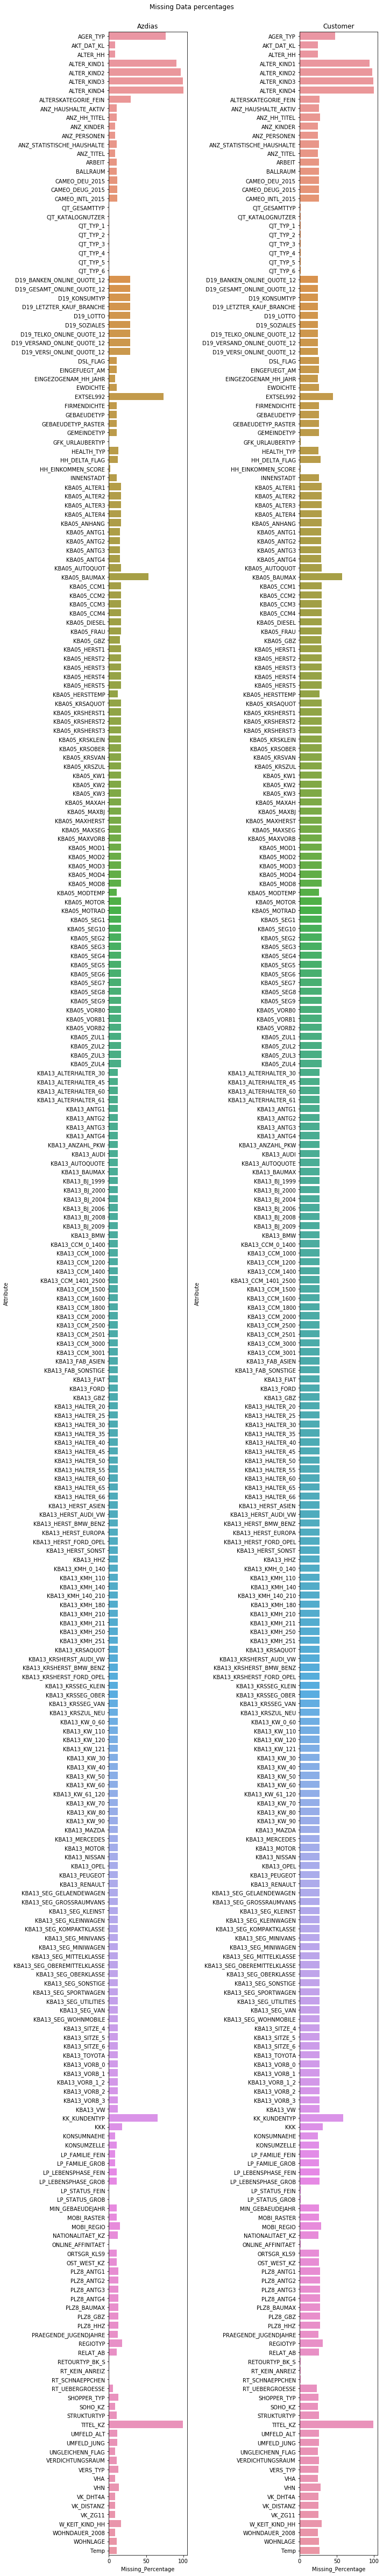

In [33]:
#Plotting the percentage of missiing poins in each column
def plot_percentage_missing(df1, df2, percentage=0, figsize=(10,70)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    features and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)

    fig.suptitle("Missing Data percentages")

    ax = fig.add_subplot(121)
    ax.set_title("Azdias")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df1[df1.Missing_Percentage>percentage], ax= ax)

    ax = fig.add_subplot(122)
    ax.set_title("Customer")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df2[df2.Missing_Percentage>percentage], ax= ax)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    # fig.tight_layout()
    plt.show()
    
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=0)

As we can see there are many columns where data is missing. There is also a overlap in both Azdias and Customers dataframes, actually the values coincide a lot in both dataframes, which we can infere that customers data is a subset of azdias data. So, in order to remove missing data we wil establish a threshold of 30%, where columns with more than 30% of missing data will be removed from our analysis.

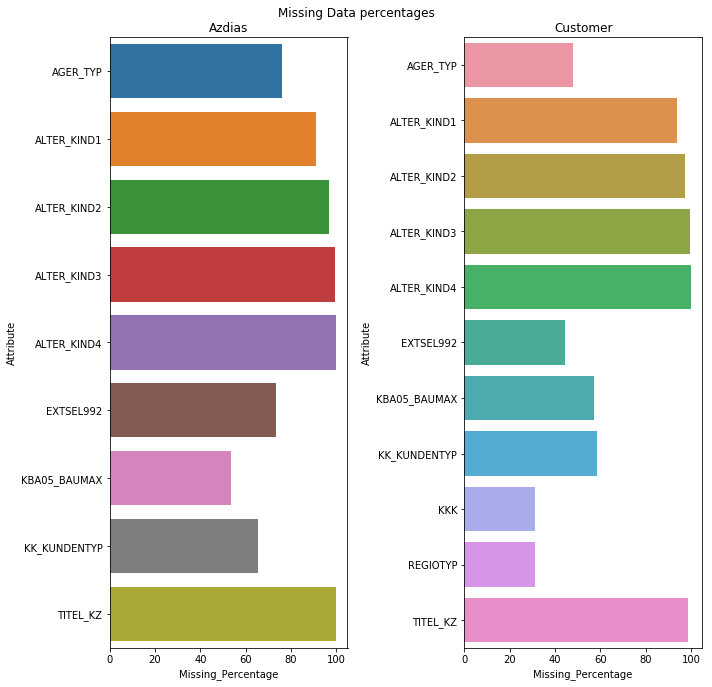

In [34]:
#Checking the Columns where the missing data amount is higher than 30%
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=30, figsize=(10, 10))

In AZDIAS we have 9 columns with more than 30% missing data, in Customer there is 11 columns with the same amount. When comparing with the total of columns that have missing data, there is a small amount and we can drop them.

In [35]:
def remove_columns(df, remove_cols):
    """
    Drops given list of columns from df.
    """
    df = df.drop(remove_cols, axis = 1)
    return df

def remove_missing_columns(df1, df2, df1_missing, df2_missing, threshold=30):
    """
    Drops columns from df1 and df2 with given threshold.
    
    Uses df1_missing and df2_missing to determing which columns to remove.
    If df1_missing has more missing columns (missing_percentage > threshold),
    then df1_missing is taken as reference and vice versa.
    """
    
    removable_cols1 = df1_missing[df1_missing.Missing_Percentage > threshold]
    removable_cols2 = df2_missing[df2_missing.Missing_Percentage > threshold]
    
    if len(removable_cols1) > len(removable_cols2):
        remove_cols = removable_cols1.Attribute.tolist()
    else:
        remove_cols = removable_cols2.Attribute.tolist()
         
    df1 = remove_columns(df1, remove_cols)
    df2 = remove_columns(df2, remove_cols)
    print(f"\t\tRemoved {len(remove_cols)} columns from given dataframes")
    
    return (df1, df2, remove_cols)

In [36]:
print("Number of columns After dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

Number of columns After dropping
Azdias - 367
Customers - 370


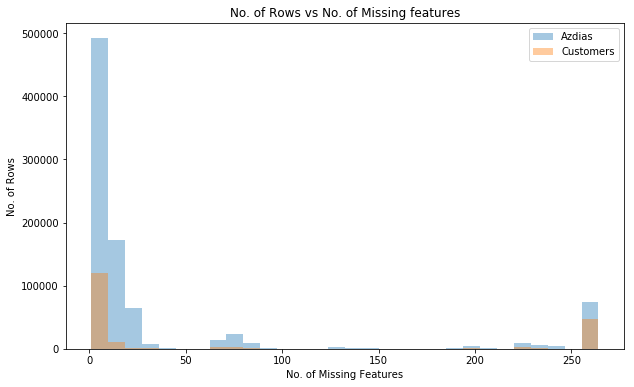

In [37]:
#After removing the columns which have more than 30% missing values, now we can look at the dataframes with remaining features for any missing values in rows.
def plot_missing_rowwise_histogram(df1, df2, bins=30, figsize=(10,6)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    """
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("No. of Rows vs No. of Missing features")
    ax.set_xlabel("No. of Missing Features")
    ax.set_ylabel("No. of Rows")
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()
    
plot_missing_rowwise_histogram(azdias, customers)

We have more than 700000 rows with missing data, Azdias has more missing rows than customers, most features have less than 50 missing values in both dataframes. SO we will drop all the rows which have more than 50 missing values.

In [38]:
#Dropping any missing row above the threshold
def remove_missing_rows(df, threshold, name=""):
    """
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    """
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
    
    print(f"\t\tRemoved {removed_rows} rows from {name} dataframe")
    
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df

In [39]:
print("Number of rows Before dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

customers = remove_missing_rows(customers, threshold=50)
azdias = remove_missing_rows(azdias, threshold=50)

print("Number of rows After dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

Number of rows Before dropping
Azdias - 891221
Customers - 191652
		Removed 57406 rows from  dataframe
		Removed 153933 rows from  dataframe
Number of rows After dropping
Azdias - 737288
Customers - 134246


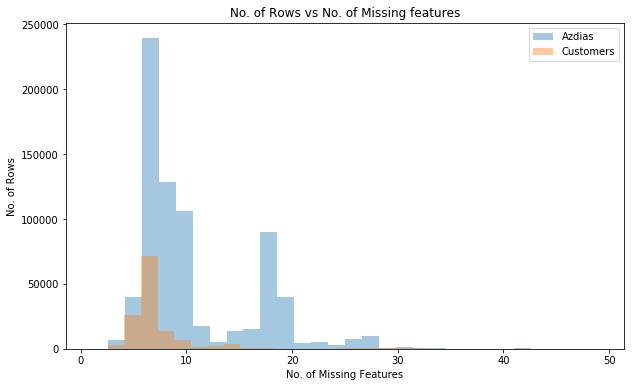

In [40]:
#Plotting again the chart to see if the rows were sucessfully dropped
plot_missing_rowwise_histogram(azdias, customers)

In [41]:
#Checking the categorical columns in both dataframes
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737288 entries, 0 to 737287
Columns: 367 entries, LNR to Temp
dtypes: float64(277), int64(87), object(3)
memory usage: 2.0+ GB


In [42]:
#Checking the categorical columns in both dataframes
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134246 entries, 0 to 134245
Columns: 370 entries, LNR to Temp
dtypes: float64(277), int64(88), object(5)
memory usage: 379.0+ MB


In [43]:
#Isolating the categorical columns in each dataframe
azdias_object_cols = azdias.columns[azdias.dtypes == "object"]
customer_object_cols = customers.columns[customers.dtypes == "object"]

print("Azdias columns with dtype Object \n",azdias_object_cols.values)
print("Azdias columns with dtype Object \n",customer_object_cols.values)

Azdias columns with dtype Object 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ']
Azdias columns with dtype Object 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ' 'PRODUCT_GROUP'
 'CUSTOMER_GROUP']


In [44]:
#Checking the unique values in the categorical columns
for col in azdias_object_cols:
    print("\nColumn ",col)
    print(azdias[col].value_counts())


Column  CAMEO_DEU_2015
6B    54006
8A    50776
4C    43988
2D    32906
7A    32630
3C    32565
3D    32176
8B    31262
4A    30254
8C    30147
9D    26746
9B    25888
7B    22921
9C    22919
9A    20057
2C    17742
8D    16675
6E    15598
5D    14071
2B    14042
6C    13868
2A    11921
1D    11457
1A    10167
5A     9721
5B     9691
5C     9050
4B     8284
7C     8127
4D     8051
6A     6416
3A     5871
6D     5756
3B     5709
6F     5048
4E     5005
1E     4783
7D     4431
7E     4375
1C     4012
5F     3939
9E     3841
1B     3815
5E     3241
XX      284
Name: CAMEO_DEU_2015, dtype: int64

Column  D19_LETZTER_KAUF_BRANCHE
D19_UNBEKANNT             179081
D19_VERSICHERUNGEN         52220
D19_SONSTIGE               40546
D19_VOLLSORTIMENT          31292
D19_SCHUHE                 28486
D19_BUCH_CD                25643
D19_VERSAND_REST           23398
D19_DROGERIEARTIKEL        21371
D19_BANKEN_DIREKT          20993
D19_BEKLEIDUNG_REST        19147
D19_HAUS_DEKO              18823
D19_

So, `OST_WEST_KZ` contains information about the history of the person i.e. which part of Germany they belonged to before unification. We can encode values in this column with pd_dummies or a label encoder. `D19_LETZTER_KAUF_BRANCHE` and `CAMEO_DEU_2015` can be removed since wont be relevant in our analysis

In [45]:
remove_extra_cols = ["D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]

azdias = remove_columns(azdias, remove_extra_cols)
customers = remove_columns(customers, remove_extra_cols)

In [46]:
#Enconding the OST_WEST_KZ colum:
def fix_ost_west_col(df):
    """
    Function to label encode the feature "OST_WEST_KZ"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    return df

azdias = fix_ost_west_col(azdias)
customers = fix_ost_west_col(customers)

In [47]:
#Enconding the ANREDE_KZ  colum:
def fix_anrede_col(df):
    """
    Function to label encode the feature "ANREDE_KZ"
    """
    df["ANREDE_KZ"] = df["ANREDE_KZ"].replace({1: 0, 2: 1})
    
    return df

azdias = fix_anrede_col(azdias)
customers = fix_anrede_col(customers)

In [48]:
#Splitting the CAMEO_INTL_2015 into two new columns:
def fix_cameo_intl_col(df):
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    return df

azdias = fix_cameo_intl_col(azdias)
customers = fix_cameo_intl_col(customers)


In [49]:
#Fixing WOHNLAGE column that have 0 values score.
def fix_wohnlage_col(df):
    """
    Function to remove '0' from "WOHNLAGE" 
    """
    df["WOHNLAGE"] = df["WOHNLAGE"].replace({0: np.nan})
    
    return df

azdias = fix_wohnlage_col(azdias)
customers = fix_wohnlage_col(customers)

In [50]:
#Splitting the customers dataframe into two, separating the extra columns from the common ones
customer_extra_cols = customers[extra_cols_in_customers]
customers = customers.drop(extra_cols_in_customers, axis = 1)

In [51]:
#Imputing values on the remaing rows. Since it is demographic data we will imput the most common values using Imputer
imputer = Imputer(strategy="most_frequent")

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

In [52]:
#Feature Scaling the cleanead data to make sure all columns have the same range
scaler = StandardScaler()

scaler.fit(azdias)

azdias = pd.DataFrame(scaler.transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [53]:
#Checking the final shape of the dataframes
azdias.shape, customers.shape, customer_extra_cols.shape

((737288, 364), (134246, 364), (134246, 3))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Dimensionality Reduction

> We will use Principal Component Analysis (PCA) in order to find out how much each feature is varying. Since, the number of features in the data is relatively high it is faster using this statistical approach than checkin one by one.


In [54]:
pd.set_option("display.max_colwidth", 200)

def perform_pca(data, n_components=None):
    pca = PCA(n_components, random_state=SEED)
    pca.fit(data)
    data_transformed = pca.transform(data)
    return pca, data_transformed

In [55]:
pca_azdias, _ = perform_pca(azdias, None)

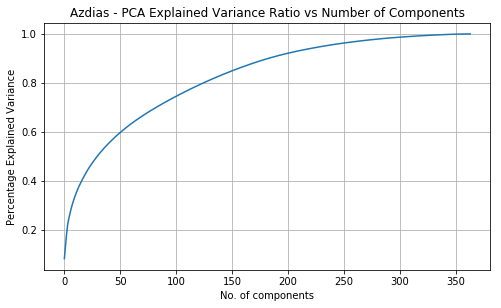

In [56]:
#Creating a function to plot the PCA variance
def plot_pca_exp_variance(pca_azdias, cumulative=True, figsize=(8,10)):
    """
    Takes in two PCA models (which are fit on corresponding data) and plots 
    their Explained Variance vs Number of components
    
    """   
    
    if cumulative:
        azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
        y_label = "Percentage Explained Variance"
    else:
        azdias_variance = pca_azdias.explained_variance_ratio_
        y_label = "Explained Variance Ratio"
        
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(211)
    ax.plot(azdias_variance)
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("Azdias - PCA Explained Variance Ratio vs Number of Components")
    ax.grid()
    plt.show()
    
plot_pca_exp_variance(pca_azdias)

We can see by the plot that around 150 features explain around 90% of total variance. So, we are going to set the number of components to 150 and perform PCA again, then we can see the feature importances for each component in the analysis.

### PCA Components Interpretation

In [57]:
#Creating a function to check features importance for a given component
def plot_feature_weights(df, pca, attributes_info, dimension, n_weights = 5, plot=True,figsize=(7,8)):
    """
    This function displays interesting features of the selected dimension
    """
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in attributes_info.Attribute.values:
            feat_descs.append(attributes_info[attributes_info.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("No description given")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values("FeatureWeight", inplace=True, ascending=False)
           
    if plot:
        fig = plt.figure(figsize=figsize)

        ax = fig.add_subplot(211)
        ax.bar(feat_names, feat_weights)
        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.grid()

        fig.tight_layout()
        plt.show()
    
    return component_info

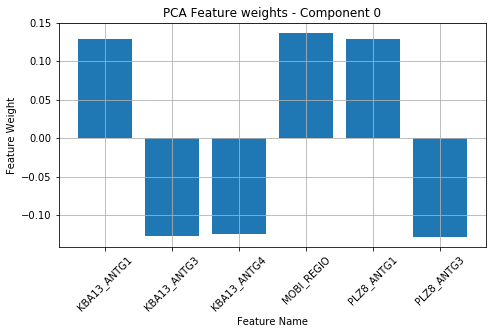

,Feature,Description,FeatureWeight
2,MOBI_REGIO,moving patterns,0.136591
1,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.129638
0,KBA13_ANTG1,No description given,0.128969
5,KBA13_ANTG4,No description given,-0.124159
4,KBA13_ANTG3,No description given,-0.127560
3,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.128308


In [58]:
#Checking component 0
component_0_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 0, 3)
component_0_info.head(10)

The results for component 0 were that it has a high positive weight to moving patterns and 1-2 family houses in the PLZ8 and negative weight on 6-10 family houses in the PLZ8. Interesting KBA13 features with no description given had positive and negative weights.

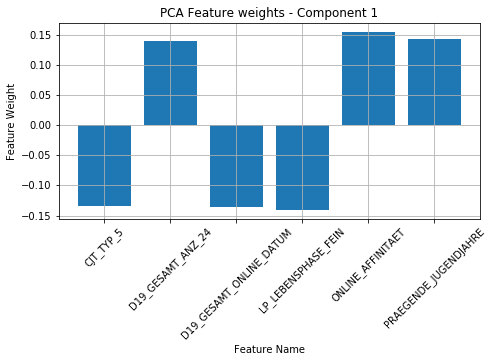

,Feature,Description,FeatureWeight
2,ONLINE_AFFINITAET,online affinity,0.154768
1,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (avantgarde or mainstream),0.143306
0,D19_GESAMT_ANZ_24,No description given,0.140687
5,CJT_TYP_5,No description given,-0.134127
4,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the complete file ONLINE,-0.136540
3,LP_LEBENSPHASE_FEIN,lifestage fine,-0.141184


In [59]:
#Checking component 1
component_1_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 1, 3)
component_1_info.head(10)

The results for component 1 were that it has a  positive weight online affinity and dominating movement in the person's youth and negative weight to features containing information about when was the last transaction made.

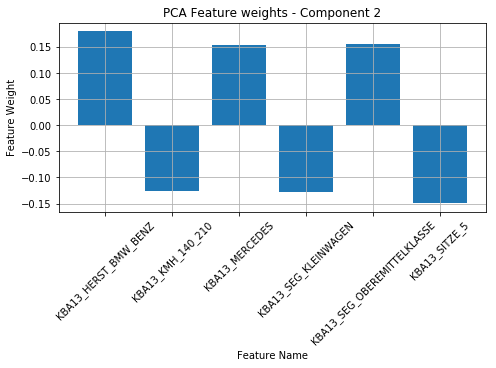

,Feature,Description,FeatureWeight
2,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.179700
1,KBA13_SEG_OBEREMITTELKLASSE,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)",0.155522
0,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.153594
5,KBA13_KMH_140_210,share of cars with max speed between 140 and 210 km/h within the PLZ8,-0.126278
4,KBA13_SEG_KLEINWAGEN,"share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8",-0.128313
3,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.149327


In [60]:
#Checking component 2
component_2_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 2, 3)
component_2_info.head(10)

The results for component 2 were that it has a positive on BMW and Mercedes owners and negative weight on small and lower class car owners.

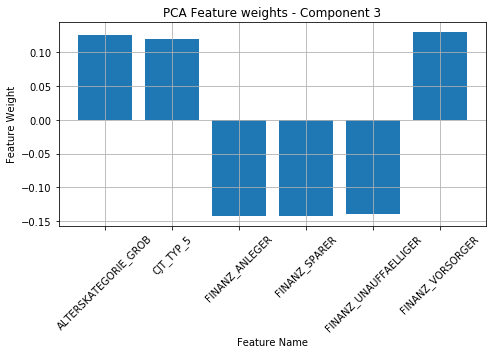

,Feature,Description,FeatureWeight
2,FINANZ_VORSORGER,financial typology: be prepared,0.130964
1,ALTERSKATEGORIE_GROB,age through prename analysis,0.125424
0,CJT_TYP_5,No description given,0.120087
5,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,-0.139192
4,FINANZ_SPARER,financial typology: money saver,-0.142185
3,FINANZ_ANLEGER,financial typology: investor,-0.143135


In [61]:
#Checking component 3
component_3_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 3, 3)
component_3_info.head(10)

The results for component 3 were that it has a positive finance prepared people and also on age through prename and negative weight on investors and money savers.

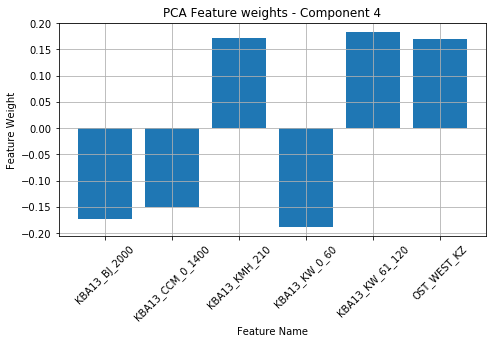

,Feature,Description,FeatureWeight
2,KBA13_KW_61_120,share of cars with an engine power between 61 and 120 KW - PLZ8,0.182506
1,KBA13_KMH_210,No description given,0.171558
0,OST_WEST_KZ,flag indicating the former GDR/FRG,0.170688
5,KBA13_CCM_0_1400,share of cars with less than 1401ccm within the PLZ8,-0.149944
4,KBA13_BJ_2000,share of cars built between 2000 and 2003 within the PLZ8,-0.172656
3,KBA13_KW_0_60,share of cars with less than 61 KW engine power - PLZ8,-0.187615


In [62]:
#Checking component 4
component_4_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 4, 3)
component_4_info.head(10)

Component 4 shows that people with share of cars with less than 61KW engine has highest negative weight and cars with engine power between 61 and 120KW has highest positive weight.The origins of the person i.e. where they belonged before German unification is also having a positive weight.Some other car specifications are playing an impact on this component.

### K-Means Clustering
After reducing the number of dimensions, we will now use the K-Means Clustering algorithm to cluster the general population into different segments.

In [63]:
pca_150, azdias_pca_150 = perform_pca(azdias, n_components=150)

In [64]:
def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        start = time.time()
        
        kmeans = KMeans(n, random_state=SEED)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Done! Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(K_start, K_end+1, step)

In [65]:
%%time
scores, range_ = get_Kmeans_scores(azdias_pca_150, 2, 20, 1)

Performing K-Means clustering
Given range min:2, max:20, step:1

Training for n_clusters:  2
Done! Score:  210996809.575
Time elapsed: 78.52 sec.

Training for n_clusters:  3
Done! Score:  203213880.16
Time elapsed: 109.29 sec.

Training for n_clusters:  4
Done! Score:  198675964.62
Time elapsed: 158.96 sec.

Training for n_clusters:  5
Done! Score:  194870567.553
Time elapsed: 200.29 sec.

Training for n_clusters:  6
Done! Score:  191997717.945
Time elapsed: 251.52 sec.

Training for n_clusters:  7
Done! Score:  189458986.323
Time elapsed: 294.26 sec.

Training for n_clusters:  8
Done! Score:  187395673.024
Time elapsed: 326.04 sec.

Training for n_clusters:  9
Done! Score:  185558833.418
Time elapsed: 300.75 sec.

Training for n_clusters:  10
Done! Score:  184174992.163
Time elapsed: 413.71 sec.

Training for n_clusters:  11
Done! Score:  182930010.312
Time elapsed: 536.65 sec.

Training for n_clusters:  12
Done! Score:  181784145.128
Time elapsed: 587.77 sec.

Training for n_cluster

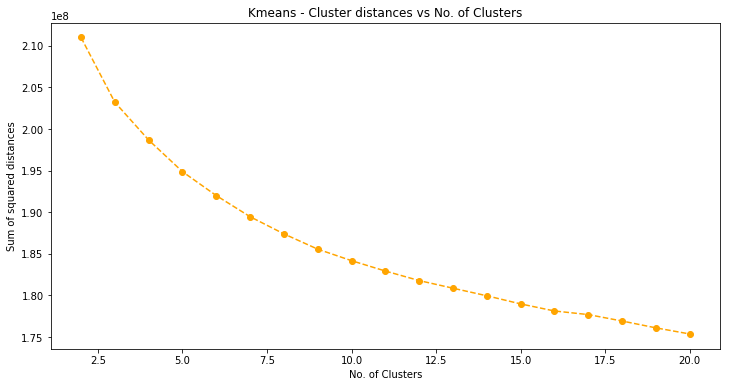

In [66]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="orange")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()
    
plot_elbow(scores, range_)

### Defining the number of clusters
From the elbow plot above, it is possible to define 10 as the optimal number of clusters since the sum of squared error decreasing a way less rate after that point, so adding one more cluster will not reduce the sum of square distances between the clusters.

In [73]:
#Fitting KMeans to 10 clusters
kmeans = KMeans(10, random_state=SEED)
kmeans.fit(azdias_pca_150)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=2, tol=0.0001, verbose=0)

In [74]:
#Predicting the cluster to the AZDIAS dataframe
azdias_clusters = kmeans.predict(azdias_pca_150)

In [75]:
#Transforming the customers_pca_150 dataframe using the customers dataframe
customers_pca_150 = pca_150.transform(customers)

In [76]:
#Predicting the cluster to the CUSTOMERS dataframe
customers_clusters = kmeans.predict(customers_pca_150)

In [77]:
#Checking the results
print(azdias_clusters[:15], "\n",customers_clusters[:15])

[8 8 3 1 3 8 8 4 4 9 8 8 4 6 8] 
 [3 9 3 1 5 5 5 4 5 5 0 9 5 5 0]


In [79]:
#Creatind a panda series from clusters
customers_clusters = pd.Series(customers_clusters)
azdias_clusters = pd.Series(azdias_clusters)

In [80]:
#Checking the number of customers per cluster
cluster_info = pd.DataFrame([])

cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

cluster_info

,Cluster,Population,Customers
0,0,79284,15837
1,1,59886,3811
2,2,45203,3353
3,3,99442,25816
4,4,53587,11024
5,5,72241,54140
6,6,80120,1848
7,7,51851,2608
8,8,104430,1165
9,9,91244,14644


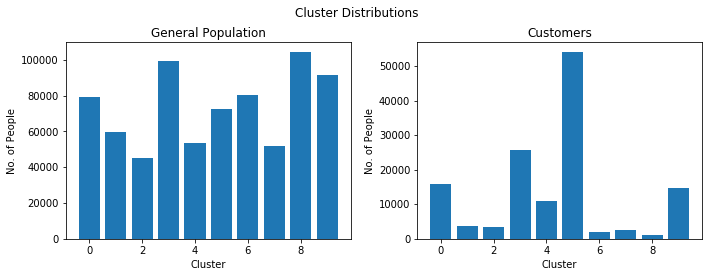

In [81]:
#Plotting the number number of customers per cluster
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [82]:
#Checking the percentage of customers is present in each cluster
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)

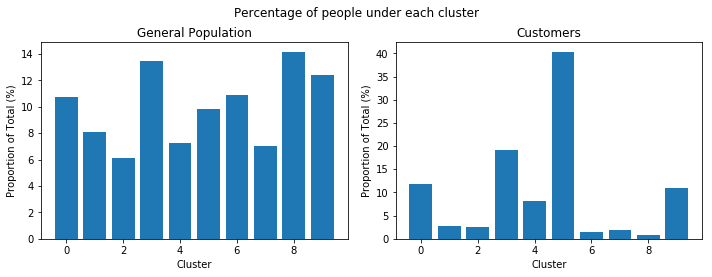

In [83]:
#Plotting the results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Pop_proportion"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Cust_proportion"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
ax2.set_title("Customers")

fig.suptitle("Percentage of people under each cluster")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The  distribution of the customers in the AZDias dataframe is close to smooth, but when we check the results on the Customers dataframe it is possible to see that most customers are place in the clusters XXX

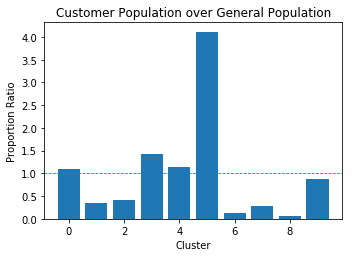

In [84]:
#Checking the ratio of customers considering the AZDias dataframe in each cluster
##This ratio helps us to identify what custer has the most potential for users to become customers.
cluster_info["Cust_over_Pop"] = cluster_info["Cust_proportion"] / cluster_info["Pop_proportion"]

fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.bar(cluster_info["Cluster"], cluster_info["Cust_over_Pop"])
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("Customer Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

When The ratio is higher than 1, it indicates that the cluster contains more actual customers than users from AZDIAS dataframe, and there is more probability of the prople belonging to these clusters being future customers.

The ratio between proportions of customers and population gave an idea about what proportion of customers are there in each cluster.
This also gives an idea about which cluster can be targetted for future customers.

### Clusters Characteristics 
If there is any need to understand better what are the characteristics that define each cluster we can run a simple check on the PCA weights and extract valuable information. Let's exercise that on the first cluster.

In [89]:
#Creating a function to extract the PCA weights for the clusters
def explain_cluster(kmeans_model, cluster_no, data, pca_model, attributes_info, num_components=2, num_feat_per_comp=3):
    
    weights = kmeans_model.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=num_components).iterrows():
        
        component_info = plot_feature_weights(data, pca_model, attributes_info, 
                                                int(row["Component"]), num_feat_per_comp, False)
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos)
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info

In [91]:
#Checking the results on the cluster 0
cluster_0 = explain_cluster(kmeans, 0, azdias, pca_150, attributes_info)
cluster_0

,Component,ComponentWeight,Feature,Description,FeatureWeight
2,0,7.856286,MOBI_REGIO,moving patterns,0.136591
1,0,7.856286,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.129638
0,0,7.856286,KBA13_ANTG1,No description given,0.128969
5,0,7.856286,KBA13_ANTG4,No description given,-0.124159
4,0,7.856286,KBA13_ANTG3,No description given,-0.127560
3,0,7.856286,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.128308
2,0,7.856286,ONLINE_AFFINITAET,online affinity,0.154768
1,0,7.856286,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (avantgarde or mainstream),0.143306
0,0,7.856286,D19_GESAMT_ANZ_24,No description given,0.140687
5,0,7.856286,CJT_TYP_5,No description given,-0.134127


From that exercise it is possible to extract information on what are the Characteristics of people in each cluster. This can help better understand the existing customers and their behaviour according to demographics and any other data collected.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [54]:
#Getting the train data
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
#Checking the data shape
mailout_train.shape

(42962, 367)

In [56]:
#Checking the first rows
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


0    42430
1      532
Name: RESPONSE, dtype: int64


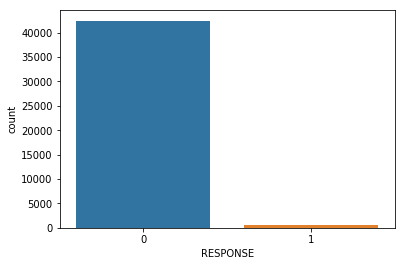

In [57]:
#Checking the target feature
print(mailout_train.RESPONSE.value_counts())
sns.countplot("RESPONSE", data=mailout_train)

It is possible to see that our hada is highly imbalanced. There are more than 40,000 records with negative response and only 532 with positive response. Considering this disprecancy, accuracy wil be a bad metric to choose because even if the model predicts all data as zeros it will give a 98% accuracy. So, in order to fix this issue, we had to choose a metric that will consider this imbalance, so for this project we used Precision, Recall or Area under Receiver Operating Curve (AUROC). <br>

Where: <br>
Precision = True Positives / (True Positives + False Positives) <br>
Recall = True Positives / (True Positives + False Negatives) <br>
True Positive Rate = True Positives / (True Positives + False Negatives) <br>
False Positive Rate = False Positives / (False Positives + True Negatives)

Since we were aiming to tell whether a user will be a customer or not. AUROC metric which take into consideration both true positive rate and false positive rate were a good choice, because we were able to predict both cases.

### Cleaning the train data
Before moving further we needed to perform the same cleaning steps now on the train data, so in order to achieve that we consolidated all steps into a function

In [58]:
def clean_data_for_supervised(cleaned_azdias, df, attributes_values):
    
    print("Cleaning Given Dataframe")
    
    start = time.time()
    
    # Forward fill attribute_values dataframe, to access required columns and corresponding info
    attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
    
    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(df.columns[18:20])
        
    # Ignore if these cols are already cleaned 
    if not (df[warning_cols[0]].dtype == 'float64') & (df[warning_cols[1]].dtype == 'float64'):
        df = fixing_cameo_columns(df)
        
        
    print("\tFixing LP_* columns")
    df = fixing_LP_columns(df)
    
    print("\tFixing EINGEFUGT column")
    df = fixing_eigefugt_column(df)
    
    # Replacing "Unkown" values with "np.nan"
    print("\tReplacing 'unkown' values with 'NaN'")
    unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
    
    df = replacing_unknown(df, unkown_attributes_values, verbose=False)
    
    # Encoding OST_WEST_KZ col
    print("\tEncoding OST_WEST_KZ column")
    df = fix_ost_west_col(df)

    print("\tEncoding ANREDE Column")
    df = fix_anrede_col(df)
    
    print("\tEncoding CAMEO_INT column")
    df = fix_cameo_intl_col(df)
    
    print("\tEncoding WOHNLAGE column")
    df = fix_wohnlage_col(df)
    
    
    # Dropping columns which are not in azdias
    print("\tDropping extra columns")
    cols_to_drop = [col for col in df.columns if col not in azdias.columns]
#     cols_to_drop += ["EINGEFUEGT_AM", "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]
    
    df = remove_columns(df, cols_to_drop)
    
    
    # Imputing Missing data
    print("\tImputing missing values with most frequent ones")
    imputer = Imputer(strategy="most_frequent")
    
    imputer.fit(azdias)
    df = pd.DataFrame(imputer.transform(df), columns = df.columns)
    
    end = time.time()
    
    print(f"Completed Cleaning in {end-start} seconds")
    
    return df

In [59]:
labels = mailout_train["RESPONSE"]
mailout_train_LNR = mailout_train["LNR"]

In [60]:
mailout_train = clean_data_for_supervised(azdias, mailout_train, attributes_values)

Cleaning Given Dataframe
	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Encoding OST_WEST_KZ column
	Encoding ANREDE Column
	Encoding CAMEO_INT column
	Encoding WOHNLAGE column
	Dropping extra columns
	Imputing missing values with most frequent ones
Completed Cleaning in 74.59043860435486 seconds


In [61]:
#checking the new shape of the train data
mailout_train.shape

(42962, 364)

### Defining a benchmark
We trained a Logistic Regression on unscaled data to set a benchmark result that we used as baseline

In [62]:
#Definig the parameters
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2, random_state=SEED)

In [63]:
#Calling the model
lr = LogisticRegression(random_state=SEED)

In [64]:
#Fitting the model
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
#Predicting the results
pred = lr.predict_proba(X_val)[:,1]
pred

array([ 0.04043099,  0.01037424,  0.00531453, ...,  0.00856049,
        0.01167807,  0.0098127 ])

In [66]:
#Getting the baseline AUROC
print("Baseline AUROC - ", roc_auc_score(y_val, pred))

Baseline AUROC -  0.672752556074


### Training different models

In [67]:
#Standardzing the train data
scaler = StandardScaler()

mailout_train = pd.DataFrame(scaler.fit_transform(mailout_train), columns = mailout_train.columns)

In [68]:
#Definig the parameters
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2, random_state=SEED)

In [69]:
#Creating a function to train and predict using different models
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed    

In [70]:
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED))]

In [95]:
#Getting the results
results = {"Model":[],
          "AUROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

In [96]:
#Checking the results
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUROC_score,Time_in_sec
0,LogisticRegression,0.631793,18.2736
1,DecisionTreeClassifier,0.510325,3.72911
2,RandomForestClassifier,0.530196,1.66718
3,GradientBoostingClassifier,0.749229,48.2555
4,AdaBoostClassifier,0.709368,17.2039


Looking the results, GradientBoostingClassifier	has the highest score, but it is the slowest to train. Also AdaBoostClassifier have the next highest score (not that far from GradientBoostingClassifier) and also take less time to train. So we are going to select that algorithm for hyper parameter tuning.

### Hyper Parameter Tunning

In [73]:
#Using GridSearch to tune our best model: AdaBoostClassifier
param_grid = {"n_estimators": [50,100,150,200],
              "learning_rate": [0.01,0.1,0.5,0.9,1.],
              "algorithm":["SAMME.R"]
              }

adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=SEED), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [74]:
%%time
adaboost_grid.fit(X_train, y_train)

best_adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  13.5s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s


[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  13.4s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  13.2s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  13.1s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  13.2s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=100 .........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=100, total=  26.5s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=100 .........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=100, total=  26.0s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=100 .........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=100, total=  26.0s
[CV] algorithm=SAMME.R, learning_rate=0

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 55.2min finished


Best Score:  0.772209440653
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}
CPU times: user 55min 32s, sys: 0 ns, total: 55min 32s
Wall time: 55min 47s


In [93]:
#Predict the results for the best tuned model on the validation data
preds_adaboost = best_adaboost.predict_proba(X_val)[:,1]

print("AUROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_adaboost)))

AUROC score on validation data: 0.7739


In [76]:
def plot_feature_importances(model, model_name, feature_names, num_features=10):
    """
    Plots top n feature importances for the given model
    """

    
    feature_importance_values= np.zeros((len(model.feature_importances_)))
    
    feature_importance_values += model.feature_importances_

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Feature Importances ({model_name})') 

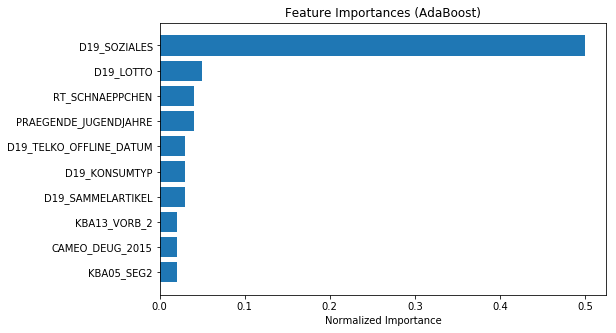

In [77]:
plot_feature_importances(model=best_adaboost, model_name="AdaBoost", feature_names=mailout_train.columns)

### Predicting the best model on new dataset
After train and hyper tunning our best model we will use it agains a new dataset for test purposes.

In [88]:
#Getting the test data
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [89]:
#Checking the test data
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [97]:
#Checking the size of test data
mailout_test.shape

(42833, 364)

In [90]:
#Cleaning the test data
mailout_test_LNR = mailout_test["LNR"]
mailout_test = clean_data_for_supervised(azdias, mailout_test, attributes_values)
mailout_test = pd.DataFrame(scaler.transform(mailout_test), columns = mailout_test.columns)

Cleaning Given Dataframe
	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Encoding OST_WEST_KZ column
	Encoding ANREDE Column
	Encoding CAMEO_INT column
	Encoding WOHNLAGE column
	Dropping extra columns
	Imputing missing values with most frequent ones
Completed Cleaning in 31.8836190700531 seconds


In [91]:
#Fitting our best model on the train data
best_adaboost.fit(mailout_train, labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=2)

In [94]:
#Predicting on the test data using our best model
preds_test_adaboost = best_adaboost.predict_proba(mailout_test)[:,1]
print("AUROC score on test data: {:.4f}".format(roc_auc_score(y_val, preds_adaboost)))

AUROC score on test data: 0.7739


# Results

- Using the PCA and K-means algorithm in order to create cluster of customers was successful, we were able to check where the actual customers of the company intersect the cluster of general segments (Clusters 0,3,4 and 5) which are segments that are more likely to convert on actual customers for the company;
- We were able to predict campaign response using machine learning by training different models using default hyperparameters, getting the best one to tune using GridSearch with a result of 0.77 AUROC_score which is pretty strong.
- With the results of this project the company can be more accurate when working on acquiring new customers both on segmentation and campaign response prediction by addressing marketing budget more accurately aiming the best converting number possible. 
